In [1]:
import sys
print(sys.version)

import warnings
warnings.filterwarnings('ignore')

3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]


In [2]:
import torch
from torch.utils import data
import torch.nn as nn

In [3]:
cifar_10_folder = './datasets/cifar-10/'
cifar_100_folder = './datasets/cifar-100/'
flower_17_folder = './datasets/flowers-17/'
flower_102_folder = './datasets/flowers-102/'

In [4]:
import dataloaders.Cifar10Dataset as cd10
import dataloaders.Cifar100Dataset as cd100
import dataloaders.Flowers17Dataset as fl17
import dataloaders.Flowers102Dataset as fl102

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#cudnn.benchmark = True

# Parameters
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 2}
max_epochs = 100


# Generators
training_set = fl102.Flowers102Dataset(flower_102_folder, dataset_type='train', device=device)
training_set.setRotation(True)
training_set.setCrop(True)
training_set.setFlip(True)
training_set.setBlur(True)
training_set.setNoise(True)
training_set.setNormalization(True, 0.5, 0.2)
training_generator = data.DataLoader(training_set, **params)

validation_set = fl102.Flowers102Dataset(flower_102_folder, dataset_type='val', device=device)
validation_set.setNormalization(True, 0.5, 0.2)
validation_generator = data.DataLoader(validation_set, **params)

test_set = fl102.Flowers102Dataset(flower_102_folder, dataset_type='test', device=device)
test_set.setNormalization(True, 0.5, 0.2)
test_generator = data.DataLoader(test_set, **params)

In [5]:
import models.CifarModel as cm
import models.FlowerModel as fm
    
#model = cm.CifarModel('cifar_100',100)
model = fm.FlowerModel('flower_102',102)
model.to(device)

print(model)

FlowerModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (block1): ResidualBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.1)
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.1)

In [6]:
model(torch.randn(1,3,100,100).to(device)).shape
#model(torch.randn(1,3,32,32).to(device)).shape

torch.Size([1, 102])

6552 train
819 val
818 test


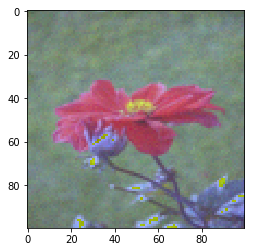

label:  tensor(55)


In [7]:
print(training_set.__len__(), training_set.dataset_type)
print(validation_set.__len__(), validation_set.dataset_type)
print(test_set.__len__(), test_set.dataset_type)

for local_X, local_y in training_generator:

    training_set.plotImage(local_X[0,:,:,:], local_y[0])
    break
    #     pass

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.00001)

In [9]:
import matplotlib.pyplot as plt

def trainModel(model, train_dataset_gen, val_dataset_gen, criterion, optimizer, num_of_epochs, device):
    
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    epochs = []
    
    model = model.to(device)
    best_val_loss = sys.float_info.max
    
    
    for epoch in range(num_of_epochs):
        print("Epoch {}/{}".format(epoch+1, num_of_epochs))
        
        for phase in ['train', 'validate']:
            
            cumulated_loss = 0.0
            cumulated_inputs_count = 0
            cumulated_acc = 0.0
            
            if phase == 'train':
                model.train()
                print(" Training ... ")
                
                for i, (inputs, labels) in enumerate(train_dataset_gen,0):
                    inputs, labels = inputs.to(device), labels.to(device)
                
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(True):
            
                        outputs = model(inputs)
                        _, preds = torch.max(outputs,1)
                        loss = criterion(outputs, labels)
                        
                        
                        loss.backward()
                        optimizer.step()
                        
                        cumulated_loss += loss.item()
                        cumulated_inputs_count += inputs.shape[0]
                        cumulated_acc += sum((preds.cpu().numpy() == labels.cpu().numpy()) == True)
                        
                        if((i+1) % 50 == 0):
                            print(' progres: {:.2f}, loss: {:.6f}, acc: {:.2f}'.format(cumulated_inputs_count/training_set.length(), cumulated_loss/cumulated_inputs_count, cumulated_acc/cumulated_inputs_count))
                        
                
                train_acc.append(cumulated_acc/cumulated_inputs_count)
                train_loss.append(cumulated_loss/cumulated_inputs_count)
                        
            else:
                model.eval()
                print(" Validating ... ")
                
                for i, (inputs, labels) in enumerate(validation_generator,0):
                    inputs, labels = inputs.to(device), labels.to(device)
                
                    with torch.set_grad_enabled(False):
            
                        outputs = model(inputs)
                        _, preds = torch.max(outputs,1)
                        loss = criterion(outputs, labels)
                        
                        cumulated_loss += loss.item()
                        cumulated_inputs_count += inputs.shape[0]
                        cumulated_acc += sum((preds.cpu().numpy() == labels.cpu().numpy()) == True)
                        
                val_acc.append(cumulated_acc/cumulated_inputs_count)
                val_loss.append(cumulated_loss/cumulated_inputs_count)
                epochs.append(epoch)
                        
                print(' loss: {:.6f}, acc: {:.2f}'.format(val_loss[-1], val_acc[-1]))
                model.save_model({
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                }, False)
                
                if(best_val_loss > cumulated_loss/cumulated_inputs_count):
                    best_val_loss = cumulated_loss/cumulated_inputs_count
                    print(' Saving best model!')
                    model.save_model({
                        'epoch': epoch + 1,
                        'state_dict': model.state_dict(),
                    }, True)
                    
        if(epoch % 5 == 1):
            
            fig, axs = plt.subplots(2, 1)
            axs[0].plot(epochs, train_acc, label='trn')
            axs[0].plot(epochs, val_acc, label='val')
            axs[0].grid(True)
            axs[0].set_xlabel('epochs')
            axs[0].set_ylabel('acc')
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            
            axs[1].plot(epochs, train_loss, label='trn')
            axs[1].plot(epochs, val_loss, label='val')
            axs[1].grid(True)
            axs[1].set_xlabel('epochs')
            axs[1].set_ylabel('loss')
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            
            plt.show()

trainModel(model, training_generator, validation_generator, criterion, optimizer, 1000,device)

Epoch 1/1000
 Training ... 


KeyboardInterrupt: 

In [10]:
model = fm.FlowerModel('flower_102',102)
model.load_model(load_best=True)
model.to(device)

print(" Testing ... ")
cumulated_loss = 0.0
cumulated_inputs_count = 0
cumulated_acc = 0.0
conf_matrix = np.zeros((102,102))

for i, (inputs, labels) in enumerate(test_generator,0):
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.set_grad_enabled(False):

        outputs = model(inputs)
        _, preds = torch.max(outputs,1)
        loss = criterion(outputs, labels)
        for label, pred in zip(labels, preds):
            conf_matrix[pred.item(), label.item()] += 1

        cumulated_loss += loss.item()
        cumulated_inputs_count += inputs.shape[0]
        cumulated_acc += sum((preds.cpu().numpy() == labels.cpu().numpy()) == True)

        
print(' loss: {:.6f}, acc: {:.2f}'.format(cumulated_loss/cumulated_inputs_count, cumulated_acc/cumulated_inputs_count))
                  

 Testing ... 
 loss: 0.045092, acc: 0.71


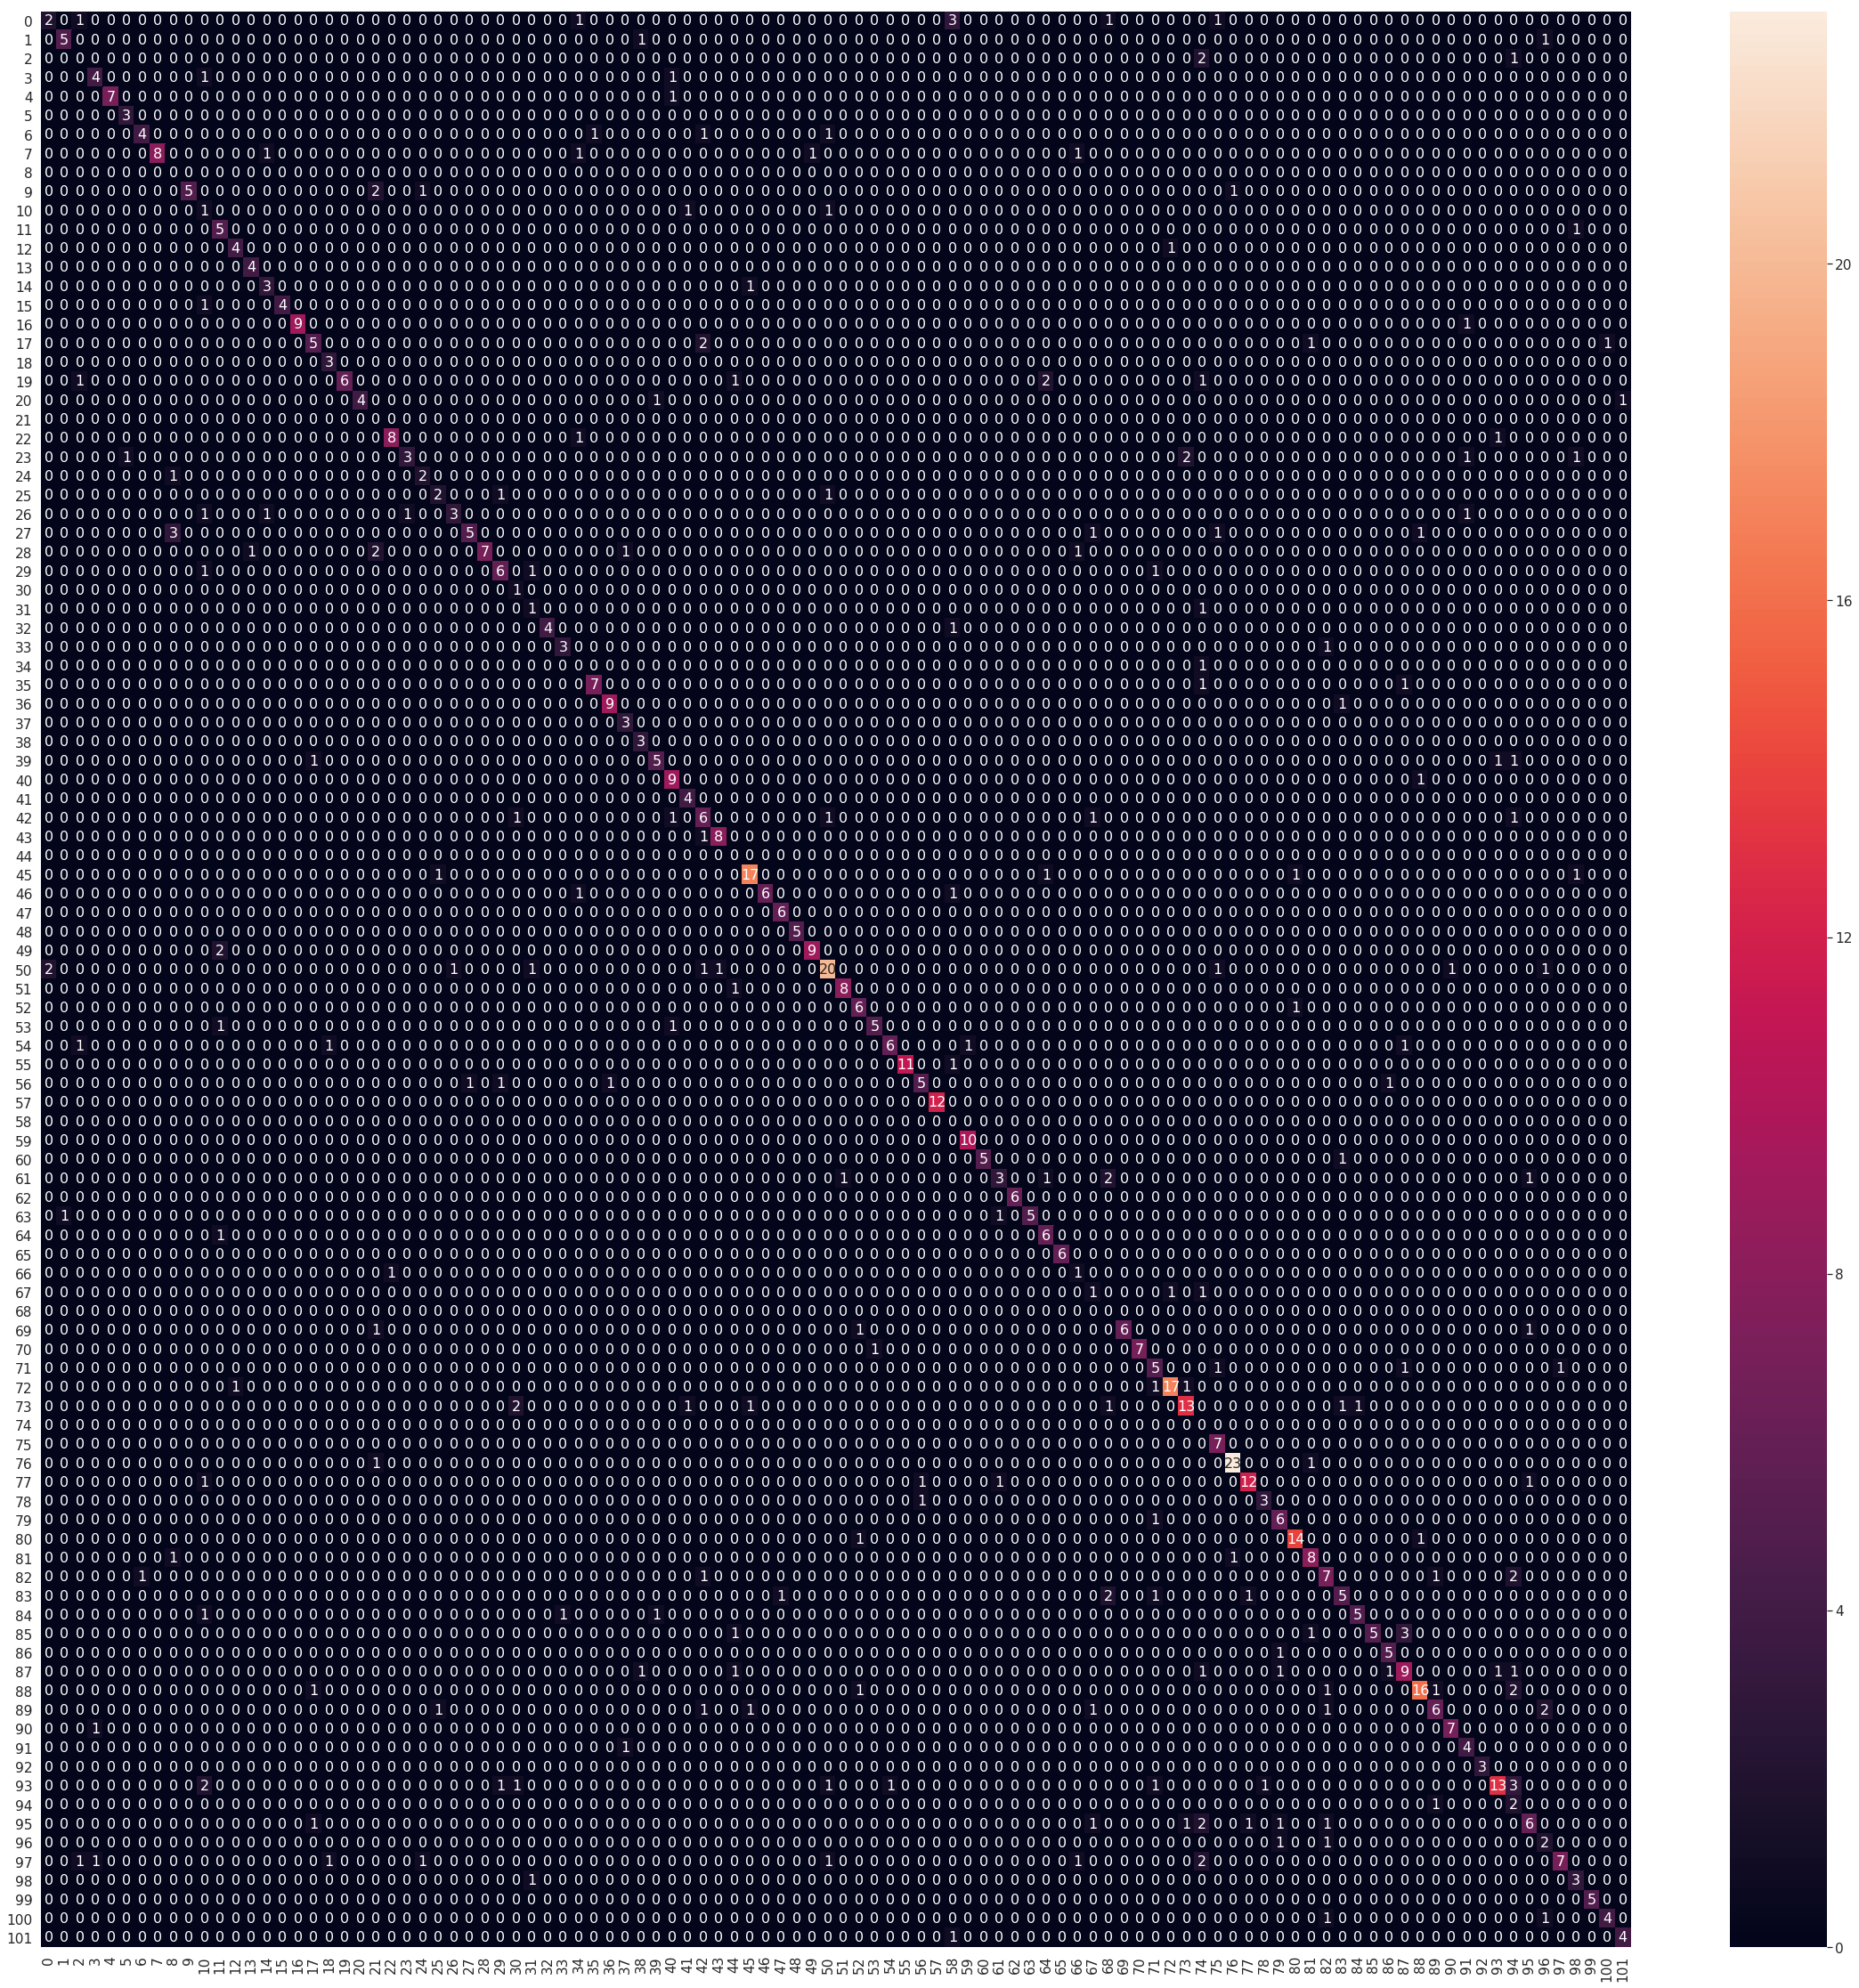

In [18]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plotConfusionMatrix(matrix):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(40,40)
    df_cm = pd.DataFrame(matrix, range(matrix.shape[0]),
                  range(matrix.shape[1]))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
    
plotConfusionMatrix(conf_matrix[:,:])